# FB Profanity check

### **Problem Statement:**
Imagine there is a file full of Facebook comments by various users and you are provided a set of words that signify profanity. Can you write a program which can indicate the degree of profanity for each sentence in the file? Write in any programming language of your choice - mention any assumptions, but remember to state them. Place the code in Google Drive and provide a shared link.

**Given:**
1. File full of Facebook comments by various users
2. profanity words= set{words}

**wap :**
* Indicate the degree of profanity for each sentence in the file

* **You have successfully written the program to derive the profanity
degree. How will you test your program?**

In [0]:
pip install pytablewriter

    100% |████████████████████████████████| 71kB 3.3MB/s 
    100% |████████████████████████████████| 235kB 9.6MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstalled python-dateutil-2.5.3


In [0]:
# Libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.externals import joblib
import nltk
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
import pytablewriter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
#import scikitplot.metrics as skplt
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn import linear_model
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
import os

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()


Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"priyagunjate","key":"46dac5bc5a9be2da5195efaf9b1ca555"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
# reading zip file
import zipfile
with zipfile.ZipFile("train.csv.zip","r") as zip_ref:
    zip_ref.extractall("training")

In [0]:
# to read file
import pandas as pd
file=pd.read_csv('training/train.csv')

print(file.shape)
print(file.head())


(159571, 8)
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0  



#### Data Descriptions:
File content with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

toxic
severe_toxic
obscene
threat
insult
identity_hate

I took this data file for kaggele competations.
Link is as https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

##### Let's Assume that  wikipedia comments as a facebbok comments.

#### Assumptions:
1.   ID = Facebook user name
2.  comment_text= facebook comment
3. obscene = comment contains profane word or not.










In [0]:
print(file.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [0]:
fb=pd.DataFrame(file,columns=['id','comment_text','obscene'])
print(fb.tail())

                      id                                       comment_text  \
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        obscene  
159566        0  
159567        0  
159568        0  
159569        0  
159570        0  


## Preprocessing of text

In [0]:

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
def cleanhtml(sentence): #function to clean the word of any html-tags
  cleanr = re.compile('<.*?>$< /><')
#cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, ' ', sentence)
  return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or 
  cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
  cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
  return cleaned

In [0]:
i=0
str1=' '
global final_string
final_string=[]

s=''
for sent in fb['comment_text'].values:
  filtered_sentence=[]
  #print(sent);
  sent=cleanhtml(sent) # remove HTMl tags

  for w in sent.split():
    for cleaned_words in cleanpunc(w).split():
      if(cleaned_words.isalpha()) :
        if(cleaned_words.lower() not in stop):
          s=(sno.stem(cleaned_words.lower())).encode('utf8')
          filtered_sentence.append(s)
        else:
          continue
      else:
        continue
  str1 = b" ".join(filtered_sentence) #final string of cleaned words
  #print("***********************************************************************")
  final_string.append(str1)
  i+=1

In [0]:
fb['CleanedText']=final_string
print(fb.tail())

                      id                                       comment_text  \
159566  ffe987279560d7ff  ":::::And for the second time of asking, when ...   
159567  ffea4adeee384e90  You should be ashamed of yourself \n\nThat is ...   
159568  ffee36eab5c267c9  Spitzer \n\nUmm, theres no actual article for ...   
159569  fff125370e4aaaf3  And it looks like it was actually you who put ...   
159570  fff46fc426af1f9a  "\nAnd ... I really don't think you understand...   

        obscene                                        CleanedText  
159566        0  b'second time ask view complet contradict cove...  
159567        0               b'asham horribl thing put talk page'  
159568        0  b'spitzer umm there actual articl prostitut ri...  
159569        0  b'look like actual put speedi first version de...  
159570        0  b'realli dont think understand came idea bad r...  


In [0]:
# installing profanity_check
pip install profanity-check

In [0]:
print(fb.head())

                 id                                       comment_text  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...   

   obscene                                        CleanedText  
0        0  b'explan edit made usernam hardcor metallica f...  
1        0  b'daww match background colour im seem stuck t...  
2        0  b'hey man im realli tri edit war guy constant ...  
3        0  b'cant make real suggest improv wonder section...  
4        0                 b'sir hero chanc rememb page that'  


In [0]:
# Train -Test splitting
clean_text=fb['CleanedText']
y_pro=fb['obscene']
X_train_data ,X_test_data,Y_train_data,Y_test_data = train_test_split(clean_text,
                                                                      y_pro.values.ravel(),
                                                                      test_size=0.3,
                                                                      shuffle=False)

# Optimal Lambda for SVM

In [0]:
# optimal_svm is function to calculate the hyperparametr c for SGD_clf
def optimal_svm(X_train,y_train,X_test, y_test,vectorization):
  C = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
  # hyperparameter options
  hp1 =dict(alpha= C)
  # Scoring options
  d=['f1','roc_auc']
  for i in tqdm(range(len(d))):
   
   
   
    p = d[i] 
    print('Scoring  Metrics',p)
    #models_performence['Scoring  Metrics'].append(p)
    SGD_clf = linear_model.SGDClassifier(loss='hinge', n_iter=100,
                                         learning_rate='optimal',
                                         class_weight='balanced',n_jobs= -1)
 
    model1 = GridSearchCV(SGD_clf,hp1,scoring = p,cv=3,n_jobs= -1)
    best_model1=model1.fit(X_train, y_train)
    Test_model_score=best_model1.score(X_test, y_test)
    Train_model_score=best_model1.score(X_train, y_train)
    print('Train_model_score',Train_model_score)
    
    
    print("Test_model_score",Test_model_score)
    optimal_l1=best_model1.best_estimator_.get_params()['alpha']
    
    print('best lambda',optimal_l1)
  print("done")

#### Error plot

In [0]:

def error_plot(classifier,p,X_train,y_train,X_test, y_test):
  C = [1000,500,100,50,10,5,1,0.5,0.1,0.05,0.01,0.005,0.001,0.0005,0.0001]
  train_error=[]
  test_error=[]
  for i in tqdm(range(len(C))):
    hp1 =dict(alpha=[C[i]])
    model1 = GridSearchCV(classifier, hp1,
    scoring =p ,
    cv=3,n_jobs= -1)
    best_model1=model1.fit(X_train, y_train)
    Test_score=model1.score(X_test, y_test)
    test_error.append(1-Test_score)
    Train_score=model1.score(X_train, y_train)
    train_error.append(1-Train_score)
  fig = plt.figure( facecolor='y', edgecolor='k')
  plt.semilogx(C,train_error,'m*',linestyle='dashed', label='Train')
  plt.semilogx(C,test_error,'r*', linestyle='dashed',label='Test')
  plt.legend(loc='lower left')
  plt.grid()

### Pandas dataframe to markdown Table format

In [0]:
# result_display is function to convert dataframe into table format in Markdown
def result_display(df):
  writer = pytablewriter.MarkdownTableWriter()
  writer.header_list = list(df.columns.values)
  writer.value_matrix = df.values.tolist()
  writer.write_table()

In [0]:
 #Vectorize the text
count_vect = CountVectorizer()
vect_Data = count_vect.fit_transform(X_train_data)
print("Original shape",vect_Data.shape)
#truncated SVD for dimesionality reduction for 100 dimensions
svd = TruncatedSVD(n_components=100,n_iter=7)
Data=svd.fit_transform(vect_Data )
print("TruncatedSVD :",Data.shape)

Original shape (111699, 101866)
TruncatedSVD : (111699, 100)


In [0]:
# StandardScaler
final_data= StandardScaler(with_mean=False).fit_transform(Data )
print(final_data.shape)
#Normalize Data
warnings.filterwarnings("ignore")

(111699, 100)


In [0]:
#vector of test data

vect_Data1= count_vect.transform(X_test_data)
print(vect_Data1.shape)
final_data_test=svd.transform(vect_Data1)
print("TruncatedSVD :",final_data_test.shape)

(47872, 101866)
TruncatedSVD : (47872, 100)


In [0]:
vectorization='BOW'
optimal_lambda = optimal_svm(final_data ,Y_train_data,final_data_test,
                             Y_test_data,vectorization)

  0%|          | 0/2 [00:00<?, ?it/s]

Scoring  Metrics f1


 50%|█████     | 1/2 [02:26<02:26, 146.67s/it]

Train_model_score 0.6717270295669775
Test_model_score 0.6362209667294413
best lambda 0.001
Scoring  Metrics roc_auc


100%|██████████| 2/2 [04:51<00:00, 146.24s/it]

Train_model_score 0.9522278826532118
Test_model_score 0.9469563783952436
best lambda 0.001
done



*  **The best lambda value=0.001  with scoring metrics='f1'**
* **The best lambda value=0.001  with scoring metrics='roc_auc'**


# SGD Classifier with  best lambda value & scoring metrics='f1'

In [0]:
hp1=dict(alpha=[0.001])
SGD_clf = linear_model.SGDClassifier(loss='log',n_iter=100,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
svm =GridSearchCV(SGD_clf,hp1,scoring ='f1',
                  cv=3,n_jobs= -1)
svm.fit(final_data ,Y_train_data)
prediction1 =svm.predict(final_data_test)

In [0]:
degree_profanity1 = svm.predict_proba(final_data_test)
print(degree_profanity1)

[[0.55819556 0.44180444]
 [0.69124512 0.30875488]
 [0.83191689 0.16808311]
 ...
 [0.78540096 0.21459904]
 [0.74979492 0.25020508]
 [0.36243396 0.63756604]]


In [0]:
dd=pd.DataFrame(degree_profanity1) 
#print(dd.head())


In [0]:
dd['SGD_clf + f1']=dd[1]

In [0]:
print(dd.tail())

              0         1  SGD_clf + f1
47867  0.913656  0.086344      0.086344
47868  0.761273  0.238727      0.238727
47869  0.785401  0.214599      0.214599
47870  0.749795  0.250205      0.250205
47871  0.362434  0.637566      0.637566


In [0]:
#Training accuracy and training error
training_score=svm.score(final_data,Y_train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.6225774225774227
training error is = 0.37742257742257734


In [0]:
Testing_score=round(accuracy_score(Y_test_data ,prediction1),5)
print("Accuracy for SGD_clf model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Bag of words is = ",Testing_error)

Accuracy for SGD_clf model with Bag of words is =  0.95452
Testing error for SGD_clf model with Bag of words is =  0.045479999999999965


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction1,average='macro'),5)
recall = round(recall_score(Y_test_data,prediction1,average='macro'),5)
precision = round(precision_score(Y_test_data ,prediction1,average='macro'),5)

In [0]:
print(classification_report(Y_test_data,prediction1))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     45347
           1       0.55      0.80      0.65      2525

   micro avg       0.95      0.95      0.95     47872
   macro avg       0.77      0.88      0.81     47872
weighted avg       0.97      0.95      0.96     47872



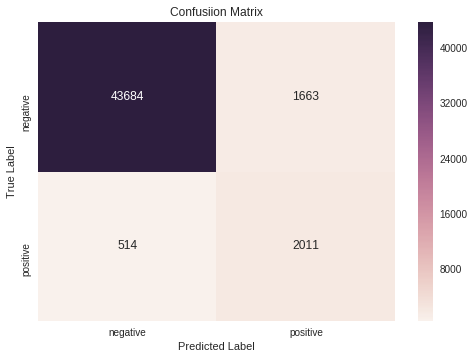

In [0]:
cm = confusion_matrix(Y_test_data ,prediction1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:23<05:31, 23.71s/it]


 13%|█▎        | 2/15 [00:45<05:01, 23.21s/it]


 20%|██        | 3/15 [01:07<04:34, 22.90s/it]


 27%|██▋       | 4/15 [01:30<04:09, 22.71s/it]


 33%|███▎      | 5/15 [01:53<03:48, 22.87s/it]


 40%|████      | 6/15 [02:15<03:23, 22.64s/it]


 47%|████▋     | 7/15 [02:38<03:01, 22.74s/it]


 53%|█████▎    | 8/15 [03:01<02:39, 22.84s/it]


 60%|██████    | 9/15 [03:24<02:16, 22.75s/it]


 67%|██████▋   | 10/15 [03:46<01:53, 22.62s/it]


 73%|███████▎  | 11/15 [04:08<01:29, 22.49s/it]


 80%|████████  | 12/15 [04:31<01:07, 22.66s/it]


 87%|████████▋ | 13/15 [04:53<00:45, 22.52s/it]


 93%|█████████▎| 14/15 [05:16<00:22, 22.48s/it]


100%|██████████| 15/15 [05:38<00:00, 22.54s/it]




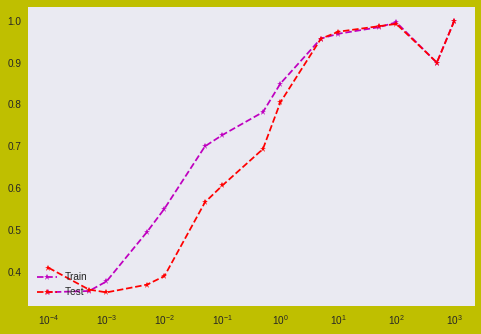

In [0]:
classifier=SGD_clf
p='f1'
error_plot(classifier,p,final_data ,Y_train_data
,final_data_test,Y_test_data)

In [0]:
models_performence1 = {
'Model':['SGD_clf+ f1'],
'Vectorizer': [vectorization],
'Optimal lambda': [0.001],
'Training error':[training_error],
'Test error':[Testing_error],
'Accuracy':[Testing_score],
'F1':[F1_score],
'recall':[recall],
'precision':[precision]
}

columns = ["Model","Vectorizer","Optimal lambda",
"Training error", "Test error",
"Accuracy","F1","recall","precision",
]
df1=pd.DataFrame(models_performence1, columns=columns)
result_display(df1)

|   Model   |Vectorizer|Optimal lambda|Training error|Test error|Accuracy|  F1  |recall|precision|
|-----------|----------|-------------:|-------------:|---------:|-------:|-----:|-----:|--------:|
|SGD_clf+ f1|BOW       |         0.001|        0.3774|   0.04548|  0.9545|0.8122|0.8799|   0.7679|


# SGD Classifier with  best lambda value & scoring metrics= 'roc_auc'

In [0]:
hp1=dict(alpha=[0.001])
SGD_clf = linear_model.SGDClassifier(loss='log',n_iter=100,
                                     learning_rate='optimal',
                                     class_weight='balanced',
                                     n_jobs= -1)
svm =GridSearchCV(SGD_clf,hp1,scoring ='roc_auc',
                  cv=3,n_jobs= -1)
svm.fit(final_data ,Y_train_data)
prediction1 =svm.predict(final_data_test)

In [0]:
degree_profanity2 = svm.predict_proba(final_data_test)
print(degree_profanity2)

[[0.55819556 0.44180444]
 [0.69124512 0.30875488]
 [0.83191689 0.16808311]
 ...
 [0.78540096 0.21459904]
 [0.74979492 0.25020508]
 [0.36243396 0.63756604]]


In [0]:
dd1=pd.DataFrame(degree_profanity2) 

In [0]:
print(dd1.shape)

(47872, 3)


In [0]:
dd1['SGD_clf + roc_auc']=dd1[1]

In [0]:
#Training accuracy and training error
training_score=svm.score(final_data,Y_train_data)
print('training accuracy=',training_score)
training_error=1-training_score
print('training error is =',training_error)

training accuracy= 0.9449688506954312
training error is = 0.05503114930456876


In [0]:
Testing_score=round(accuracy_score(Y_test_data ,prediction1),5)
print("Accuracy for SGD_clf model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Bag of words is = ",Testing_error)

Accuracy for SGD_clf model with Bag of words is =  0.95463
Testing error for SGD_clf model with Bag of words is =  0.04537000000000002


In [0]:
F1_score = round(f1_score(Y_test_data ,prediction1,average='macro'),5)
recall = round(recall_score(Y_test_data,prediction1,average='macro'),5)
precision = round(precision_score(Y_test_data ,prediction1,average='macro'),5)

In [0]:
print(classification_report(Y_test_data,prediction1))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     45347
           1       0.55      0.80      0.65      2525

   micro avg       0.95      0.95      0.95     47872
   macro avg       0.77      0.88      0.81     47872
weighted avg       0.97      0.95      0.96     47872



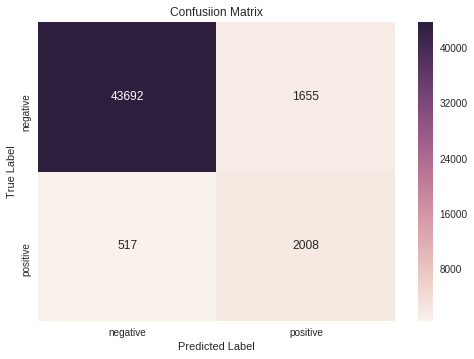

In [0]:
cm = confusion_matrix(Y_test_data ,prediction1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()




  0%|          | 0/15 [00:00<?, ?it/s]


  7%|▋         | 1/15 [00:23<05:25, 23.23s/it]


 13%|█▎        | 2/15 [00:45<04:57, 22.88s/it]


 20%|██        | 3/15 [01:08<04:34, 22.85s/it]


 27%|██▋       | 4/15 [01:30<04:08, 22.63s/it]


 33%|███▎      | 5/15 [01:52<03:46, 22.67s/it]


 40%|████      | 6/15 [02:14<03:22, 22.44s/it]


 47%|████▋     | 7/15 [02:36<02:58, 22.29s/it]


 53%|█████▎    | 8/15 [02:59<02:36, 22.29s/it]


 60%|██████    | 9/15 [03:21<02:14, 22.37s/it]


 67%|██████▋   | 10/15 [03:43<01:51, 22.31s/it]


 73%|███████▎  | 11/15 [04:05<01:28, 22.21s/it]


 80%|████████  | 12/15 [04:28<01:07, 22.42s/it]


 87%|████████▋ | 13/15 [04:50<00:44, 22.31s/it]


 93%|█████████▎| 14/15 [05:13<00:22, 22.34s/it]


100%|██████████| 15/15 [05:35<00:00, 22.32s/it]




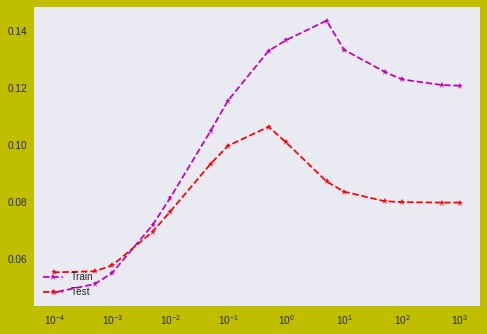

In [0]:
classifier=SGD_clf
p='roc_auc'
error_plot(classifier,p,final_data ,Y_train_data
,final_data_test,Y_test_data)

In [0]:
models_performence1['Model'].append('SGDClr + roc_auc')
models_performence1['Vectorizer'].append(vectorization)
models_performence1[ 'Optimal lambda'].append(0.001)
models_performence1['Training error'].append(training_error)
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)

In [0]:
columns = ["Model","Vectorizer","Optimal lambda",
"Training error", "Test error",
"Accuracy","F1","recall","precision",
]
df2=pd.DataFrame(models_performence1, columns=columns)

result_display(df2)

|     Model      |Vectorizer|Optimal lambda|Training error|Test error|Accuracy|  F1  |recall|precision|
|----------------|----------|-------------:|-------------:|---------:|-------:|-----:|-----:|--------:|
|SGD_clf+ f1     |BOW       |         0.001|       0.37742|   0.04548|  0.9545|0.8122|0.8799|   0.7679|
|SGDClr + roc_auc|BOW       |         0.001|       0.05503|   0.04537|  0.9546|0.8124|0.8794|   0.7682|


# Profanity_check

In [0]:
from profanity_check import predict, predict_prob

degree=predict_prob(X_train_data)
pred=predict(X_train_data)
    
  

In [0]:
dd2=pd.DataFrame(degree) 
dd2['profanity_check']=dd2
print(dd2.shape)

(111699, 2)


In [0]:
Testing_score=round(accuracy_score(Y_train_data ,pred),5)
print("Accuracy for SGD_clf model with Bag of words is = ",Testing_score)
Testing_error=1-Testing_score
print("Testing error for SGD_clf model with Bag of words is = ",Testing_error)

Accuracy for SGD_clf model with Bag of words is =  0.95764
Testing error for SGD_clf model with Bag of words is =  0.04235999999999995


In [0]:
degree1=predict_prob(X_test_data)
pred1=predict(X_test_data)

In [0]:
dd3=pd.DataFrame(degree1) 
dd3['profanity_check']=dd3

print(dd3.shape)
print(dd3.head())

(47872, 2)
          0  profanity_check
0  0.753330         0.753330
1  0.068590         0.068590
2  0.022943         0.022943
3  0.374149         0.374149
4  0.003524         0.003524


In [0]:
F1_score = round(f1_score(Y_test_data ,pred1,average='macro'),5)
recall = round(recall_score(Y_test_data,pred1,average='macro'),5)
precision = round(precision_score(Y_test_data ,pred1,average='macro'),5)

In [0]:
print(classification_report(Y_test_data,pred1))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     45347
           1       0.57      0.84      0.68      2525

   micro avg       0.96      0.96      0.96     47872
   macro avg       0.78      0.90      0.83     47872
weighted avg       0.97      0.96      0.96     47872



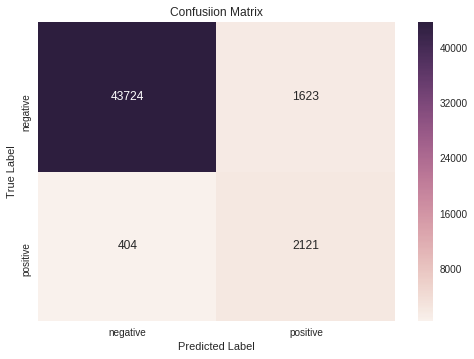

In [0]:
cm = confusion_matrix(Y_test_data ,pred1)
label = ['negative', 'positive']
df_conf = pd.DataFrame(cm, index = label, columns = label)
sns.heatmap(df_conf, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [0]:
models_performence1['Model'].append('Profanity_check(linearSVC)')
models_performence1['Vectorizer'].append('BOW')
models_performence1[ 'Optimal lambda'].append('---')
models_performence1['Training error'].append('---')
models_performence1[ 'Test error'].append(Testing_error)
models_performence1[ 'Accuracy'].append(Testing_score)
models_performence1[ 'F1'].append(F1_score)
models_performence1['recall'].append(recall)
models_performence1[ 'precision'].append(precision)
columns = ["Model","Vectorizer","Optimal lambda",
"Training error", "Test error",
"Accuracy","F1","recall","precision",
]
df3=pd.DataFrame(models_performence1, columns=columns)

result_display(df3)

|          Model           |Vectorizer|Optimal lambda|Training error|Test error|Accuracy|  F1  |recall|precision|
|--------------------------|----------|--------------|--------------|---------:|-------:|-----:|-----:|--------:|
|SGD_clf+ f1               |BOW       |         0.001|       0.37742|   0.04548|  0.9545|0.8122|0.8799|   0.7679|
|SGDClr + roc_auc          |BOW       |         0.001|       0.05503|   0.04537|  0.9546|0.8124|0.8794|   0.7682|
|Profanity_check(linearSVC)|BOW       |---           |---           |   0.04236|  0.9576|0.8270|0.9021|   0.7787|


# Observation
* Above table describes the result obtained from model.
* Here, I used SGD classifier algorithm to train and test model with various parameter.
* Profanity_check is inbuilt library in sklearn.
* The test result obtained from profanity check is much better than SGD classifier
* F1 score of profanity_check is 82.70%
* Test error is shown in table.


This program is tested with various scoring metrics (e.g. Accuracy of model which is shown in table,f1,recall,precision ) confusion metrics  and traing and testing error plot.




# Degree of profanity of each sentence with various algorithm

In [0]:
Degree_profanity123=pd.DataFrame()
Degree_profanity123['SGD_clf + f1']=dd[1]
Degree_profanity123['SGD_clf + roc_auc']=dd1[1]
Degree_profanity123['profanity_check']=dd3[0]
print(Degree_profanity123.head(10))

   SGD_clf + f1  SGD_clf + roc_auc  profanity_check
0      0.441804           0.441804         0.753330
1      0.308755           0.308755         0.068590
2      0.168083           0.168083         0.022943
3      0.012700           0.012700         0.374149
4      0.000602           0.000602         0.003524
5      0.267485           0.267485         0.104346
6      0.996782           0.996782         0.956726
7      0.286392           0.286392         0.057308
8      0.297223           0.297223         0.427891
9      0.060578           0.060578         0.107546


##  Observation
 

1.  fb['degree_profanity'] indicates the degree of profanity for each sentence in the file
2.   fb['profane'] indicates whether the sentence is offeensive or not. 

* '1' indicates offensive sentence
* '0 ' indicates not offensive sentence
I used profanity_check for checking profanity .
(No need of text preprocessing. I was trying to make profanity checker.)
* Above dataframe shows degree of profanity with various algorithm.

